In [1]:
#Inspired / borrowed / stolen from: https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

#Here we add some datetime and stats processing libraries. To test a time series stationarity, we'll use the Dickey Fuller test.

from datetime import datetime
from statsmodels.tsa.stattools import adfuller

In [2]:
#First, read in the data as a pandas dataframe
data = pd.read_csv('GE.csv')

In [3]:
#check the top of the dataframe using 'head'
data.head()

,Date,Open,High,Low,Close,Volume,"StochasticOscillator(8,5)"
0,05/08/2009,14.18,14.35,13.95,14.33,129813028,90.00
1,05/11/2009,14.18,14.22,13.90,13.99,94827338,87.69
2,05/12/2009,14.04,14.11,13.08,13.49,119778085,83.76
3,05/13/2009,13.03,13.07,12.57,12.73,108138237,69.63
4,05/14/2009,12.59,13.00,12.33,12.86,91507642,57.62


In [4]:
#convert the Date column into datetime object

data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

#check datatype of index
data.index

DatetimeIndex(['2009-05-08', '2009-05-11', '2009-05-12', '2009-05-13',
               '2009-05-14', '2009-05-15', '2009-05-18', '2009-05-19',
               '2009-05-20', '2009-05-21',
               ...
               '2009-10-05', '2009-10-06', '2009-10-07', '2009-10-08',
               '2009-10-09', '2009-10-12', '2009-10-13', '2009-10-14',
               '2009-10-15', '2009-10-16'],
              dtype='datetime64[ns]', name='Date', length=113, freq=None)

In [5]:
#select a column for the time series:
ts = data['Close']
ts.head(10)

Date
2009-05-08    14.33
2009-05-11    13.99
2009-05-12    13.49
2009-05-13    12.73
2009-05-14    12.86
2009-05-15    12.68
2009-05-18    13.28
2009-05-19    13.51
2009-05-20    13.58
2009-05-21    13.05
Name: Close, dtype: float64

/Users/thomasott/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


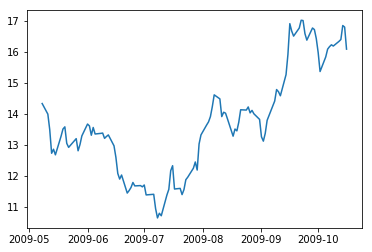

In [6]:
#check what a plot of it looks like using matplotlib
plt.plot(ts)

In [7]:
#thanks to Jacob for this handy stationarity function, saved me time writing it.
#There was a change in pandas on how to handle the rolling statistics and I updaed that in the function below

def test_stationarity(timeseries):
    
    #Determing rolling statistics. This was updated from the original post by Jacob
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

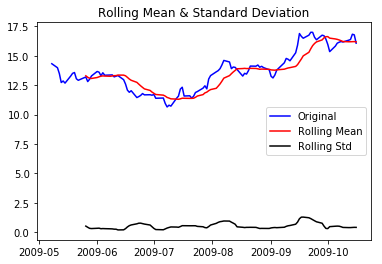

Results of Dickey-Fuller Test:
Test Statistic                  -1.040410
p-value                          0.738242
#Lags Used                       1.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


In [8]:
#check the time series stationarity for Close
test_stationarity(ts)

## This time series is NOT stationary

What this means is that rolling mean is increasing but the standard deviation is flat or falling. Plus the test statistic (-1.04) is greater than the Critical Values. 

In [9]:
ts_log = np.log(ts)

In [10]:
#Let's try the some moving average differences
#First we create a 12 day rolling moving average in Pandas
moving_avg = pd.Series(ts_log).rolling(window=12).mean()

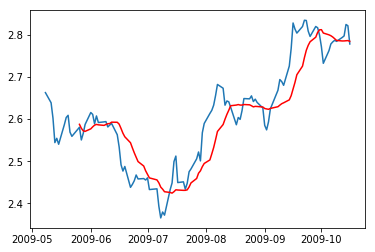

In [11]:
#Let's check the plots, looks good so far
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
#Now some magic, we subtract the prices from the moving average and check them out.
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2009-05-08         NaN
2009-05-11         NaN
2009-05-12         NaN
2009-05-13         NaN
2009-05-14         NaN
2009-05-15         NaN
2009-05-18         NaN
2009-05-19         NaN
2009-05-20         NaN
2009-05-21         NaN
2009-05-22         NaN
2009-05-26   -0.007019
Name: Close, dtype: float64

In [13]:
#Note, there's a lot of NaN's because of the subtraction of the moving average from the price, so we drop them inplace
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head(12)

Date
2009-05-26   -0.007019
2009-05-27   -0.027665
2009-05-28   -0.006121
2009-05-29    0.016417
2009-06-01    0.038672
2009-06-02    0.029550
2009-06-03    0.003220
2009-06-04    0.020090
2009-06-05    0.005475
2009-06-08    0.008270
2009-06-09    0.006937
2009-06-10   -0.007700
Name: Close, dtype: float64

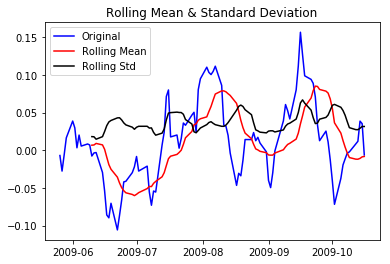

Results of Dickey-Fuller Test:
Test Statistic                  -2.920158
p-value                          0.043054
#Lags Used                       1.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


In [14]:
#Now let's check stationarity. 
test_stationarity(ts_log_moving_avg_diff)

## This is Weak Stationary

While the test statistic is -2.92, it is smaller than than the 5% value of -2.89 but by a hairs breadth. Technically we are 95% confident that this is stationary but very weakly. What you really want is to be less than the 1% crtical value so you can be 99% confident. 